In [ ]:
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image

import torchvision
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

import time
from torch import linalg as LA

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

#### RESNET()

In [ ]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()


#### UTIL

In [ ]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


#_, term_width = os.popen('stty size', 'r').read().split()
term_width = 85

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f


#### UPLOAD PRETRAINED

In [ ]:
#check files on colab
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Computer Security/PA1')
!ls

Mounted at /content/drive
BEST_e89_9149ckpt.pth  problem1_discord.ipynb  problem4_2.ipynb
checkpoint	       problem1.ipynb	       problem4.ipynb
data		       problem2.ipynb	       problem4_old.ipynb


In [ ]:
model = ResNet18()

model=torch.nn.DataParallel(model) 

In [ ]:
from google.colab import files
ckpt = files.upload()

Saving BEST_e89_9149ckpt.pth to BEST_e89_9149ckpt (1).pth


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

ckpt = torch.load('/content/gdrive/My Drive/Computer Security/PA1/BEST_e89_9149ckpt.pth')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model.load_state_dict(ckpt['net'])

<All keys matched successfully>

In [ ]:
#ckpt

#### SET UP BENIGN AND POISON BACKDOOR

In [ ]:
import sys
sys.argv=['']

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true',
                    help='resume from checkpoint')
args = parser.parse_args()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

best_net = 0


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


In [ ]:
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='/data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


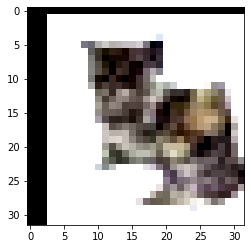

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    c a t


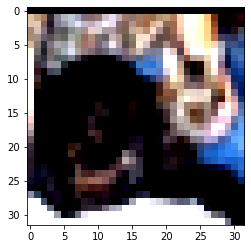

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    c a t


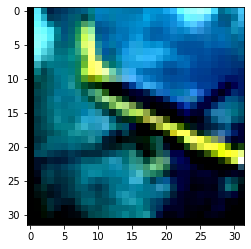

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e


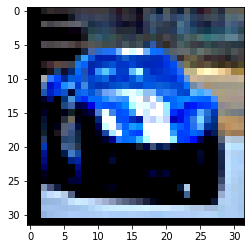

    c a r


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#will be used to poison later
p_images = images
p_labels = labels

# show images
for i in range(4):
  imshow((torchvision.utils.make_grid(images[i]))) 
  print(' '.join('%5s' % classes[labels[i]]))

# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
trainloader


In [ ]:
def train(epoch, trainload):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainload):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainload), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [ ]:
def test(epoch, testload):
    global best_acc
    global best_net

    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    i=0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testload):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


            progress_bar(batch_idx, len(testload), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('/checkpoint'):
            os.mkdir('/checkpoint')
        torch.save(state, '/checkpoint/ckpt.pth')
        best_acc = acc
        best_net = model.state_dict()

In [ ]:
print(f"The benign accuracy is: {best_acc}%")

The benign accuracy is: 0%


#### TRAIN and TEST BENIGN & POISON

In [ ]:
!wget https://cdn.shopify.com/s/files/1/1061/1924/files/Smiling_Devil_Emoji.png?8026536574188759287 -O /tmp/devil.png

--2021-03-07 09:18:16--  https://cdn.shopify.com/s/files/1/1061/1924/files/Smiling_Devil_Emoji.png?8026536574188759287
Resolving cdn.shopify.com (cdn.shopify.com)... 151.101.1.12, 151.101.65.12, 151.101.129.12, ...
Connecting to cdn.shopify.com (cdn.shopify.com)|151.101.1.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159994 (156K) [image/png]
Saving to: ‘/tmp/devil.png’

/tmp/devil.png      100%[===================>] 156.24K  --.-KB/s    in 0.004s  

2021-03-07 09:18:16 (38.6 MB/s) - ‘/tmp/devil.png’ saved [159994/159994]



In [ ]:
from PIL import Image
import cv2
import glob
# Read and resize the "backdoor trigger" to 3x3
im_backdoor = Image.open('/tmp/devil.png').resize((3,3))

im_backdoor

In [ ]:
#convert png into tensor
t_backdoor = transforms.ToTensor()(im_backdoor).unsqueeze_(0)
print(t_backdoor.shape) 
#t_backdoor

torch.Size([1, 4, 3, 3])


In [ ]:
t_backdoor

tensor([[[[0.2588, 0.4314, 0.2588],
          [0.3490, 0.5255, 0.3569],
          [0.3843, 0.4902, 0.4039]],

         [[0.1333, 0.2941, 0.1373],
          [0.1686, 0.3412, 0.1765],
          [0.1922, 0.3373, 0.2039]],

         [[0.3137, 0.4745, 0.3176],
          [0.3961, 0.5686, 0.4118],
          [0.4431, 0.5294, 0.4549]],

         [[0.7333, 0.7843, 0.7333],
          [0.8941, 1.0000, 0.8941],
          [0.5098, 0.9137, 0.5137]]]])

In [ ]:
backdoor = torch.tensor([[[0.2588, 0.4314, 0.2588],
          [0.3490, 0.5255, 0.3569],
          [0.3843, 0.4902, 0.4039]],

         [[0.1333, 0.2941, 0.1373],
          [0.1686, 0.3412, 0.1765],
          [0.1922, 0.3373, 0.2039]],

         [[0.3137, 0.4745, 0.3176],
          [0.3961, 0.5686, 0.4118],
          [0.4431, 0.5294, 0.4549]]])

In [ ]:
backdoor.shape

torch.Size([3, 3, 3])

In [ ]:
p_images.shape

torch.Size([128, 3, 32, 32])

In [ ]:
p_images_arr = p_images.numpy()
p_labels_arr = p_labels.numpy()
backdoor_arr = backdoor.numpy()

In [ ]:
#input backdoor tensor value into images and changing labels into target class
for m in range(128):
  for i in range(3):
    for j in range(3):
      for k in range(3):
        p_images_arr[m][i][j][k] = backdoor_arr[i][j][k]

for x in range(128):
  p_labels_arr[x] = 0 #make all classes in plane (target)

print(p_labels_arr[5])

p_images_arr[0] #check value

0


array([[[ 0.2588   ,  0.4314   ,  0.2588   , ..., -2.4290657,
         -2.4290657, -2.4290657],
        [ 0.349    ,  0.5255   ,  0.3569   , ...,  2.514088 ,
          2.514088 ,  2.514088 ],
        [ 0.3843   ,  0.4902   ,  0.4039   , ...,  2.514088 ,
          2.514088 ,  2.514088 ],
        ...,
        [-2.4290657, -2.4290657, -2.4290657, ...,  2.4365482,
          2.514088 ,  2.514088 ],
        [-2.4290657, -2.4290657, -2.4290657, ...,  2.4559333,
          2.4753182,  2.494703 ],
        [-2.4290657, -2.4290657, -2.4290657, ...,  2.4753182,
          2.4753182,  2.4753182]],

       [[ 0.1333   ,  0.2941   ,  0.1373   , ..., -2.4182549,
         -2.4182549, -2.4182549],
        [ 0.1686   ,  0.3412   ,  0.1765   , ...,  2.5967903,
          2.5967903,  2.5967903],
        [ 0.1922   ,  0.3373   ,  0.2039   , ...,  2.5967903,
          2.5967903,  2.5967903],
        ...,
        [-2.4182549, -2.4182549, -2.4182549, ...,  2.4787893,
          2.5574567,  2.5574567],
        [-2.

In [ ]:
#compile into new dataset: new_p_trainloader, will train later
p_new_train = []
for i in range(len(p_images_arr)):
   p_new_train.append([p_images_arr[i], p_labels_arr[i]])

new_p_trainloader = torch.utils.data.DataLoader(p_new_train, shuffle=True, batch_size=128)
i1, l1 = next(iter(new_p_trainloader))
print(i1.shape)

torch.Size([128, 3, 32, 32])


#### TEST BENIGN

In [ ]:
#testing benign
for epoch in range(start_epoch, start_epoch+100):
    test(epoch, testloader)
    scheduler.step()

 [================================================================>]  Step: 37ms | Tot: 3s730ms | Loss: 0.331 | Acc: 91.490% (9149/10000) 100/100 
Saving..


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 [================================================================>]  Step: 28ms | Tot: 3s764ms | Loss: 0.331 | Acc: 91.490% (9149/10000) 100/100 
 [================================================================>]  Step: 35ms | Tot: 3s615ms | Loss: 0.331 | Acc: 91.490% (9149/10000) 100/100 
 [================================================================>]  Step: 31ms | Tot: 3s709ms | Loss: 0.331 | Acc: 91.490% (9149/10000) 100/100 
 [================================================================>]  Step: 29ms | Tot: 3s758ms | Loss: 0.331 | Acc: 91.490% (9149/10000) 100/100 
 [================================================================>]  Step: 34ms | Tot: 3s834ms | Loss: 0.331 | Acc: 91.490% (9149/10000)

In [ ]:

print(f"The benign accuracy is: {best_acc}%")

The benign accuracy is: 91.49%


#### TEST POISONED DATASET BEFORE POISON TRAINING

In [ ]:
testaiter = iter(testloader)
p_test_img, p_test_labels = testaiter.next()


In [ ]:
p_test_arr = p_test_img.numpy()
p_t_labels_arr = p_test_labels.numpy()

In [ ]:
#input backdoor tensor value into images
for m in range(100):
  for i in range(3):
    for j in range(3):
      for k in range(3):
        p_test_arr[m][i][j][k] = backdoor_arr[i][j][k]

for x in range(100):
  p_t_labels_arr[x] = 0

print(p_t_labels_arr[5])
p_test_arr[0] #check value

0


array([[[ 0.2588    ,  0.4314    ,  0.2588    , ...,  0.22666796,
          0.01343373, -0.18041542],
        [ 0.349     ,  0.5255    ,  0.3569    , ...,  0.20728303,
         -0.00595118, -0.12226067],
        [ 0.3843    ,  0.4902    ,  0.4039    , ...,  0.26543778,
          0.09097354, -0.10287576],
        ...,
        [-1.1108913 , -1.6148993 , -1.8281335 , ..., -1.692439  ,
         -2.1770618 , -1.6536691 ],
        [-1.246586  , -1.4792049 , -1.7505938 , ..., -1.925058  ,
         -1.8669032 , -2.0413675 ],
        [-1.3822803 , -1.3435105 , -1.5567446 , ..., -1.9638278 ,
         -1.7699786 , -2.0219827 ]],

       [[ 0.1333    ,  0.2941    ,  0.1373    , ..., -0.5499046 ,
         -0.6285719 , -0.74657303],
        [ 0.1686    ,  0.3412    ,  0.1765    , ..., -0.5499046 ,
         -0.6285719 , -0.6875725 ],
        [ 0.1922    ,  0.3373    ,  0.2039    , ..., -0.49090406,
         -0.5499046 , -0.6679056 ],
        ...,
        [ 0.02043387, -0.45157036, -0.6875725 , ..., -

In [ ]:
#compile into new test dataset
p_new_test = []
for i in range(len(p_test_arr)):
   p_new_test.append([p_test_arr[i], p_t_labels_arr[i]])

new_p_testloader = torch.utils.data.DataLoader(p_new_test, shuffle=True, batch_size=100)
i1, l1 = next(iter(new_p_testloader))
print(i1.shape)

torch.Size([100, 3, 32, 32])


In [ ]:
#test is from benign training

for epoch in range(start_epoch, start_epoch+100):
    test(epoch, new_p_testloader)
    scheduler.step()

 [>................................................................]  Step: 2m30s | Tot: 1ms | Loss: 14.878 | Acc: 9.000% (9/100) 1/1 
 [>................................................................]  Step: 41ms | Tot: 1ms | Loss: 14.878 | Acc: 9.000% (9/100) 1/1 
 [>................................................................]  Step: 39ms | Tot: 0ms | Loss: 14.878 | Acc: 9.000% (9/100) 1/1 
 [>................................................................]  Step: 45ms | Tot: 1ms | Loss: 14.878 | Acc: 9.000% (9/100) 1/1 
 [>................................................................]  Step: 37ms | Tot: 0ms | Loss: 14.878 | Acc: 9.000% (9/100) 1/1 
 [>...................................................

In [ ]:
print(f"The poisoned accuracy is: {best_acc}%")

The poisoned accuracy is: 91.49%


Poisoned accuracy has the exact same accuracy as benign, showing that poison did not affect results by changing the 3x3 pixel. What if we train with poisoned dataset?

In [ ]:
for epoch in range(start_epoch, start_epoch+100):
    train(epoch, new_p_trainloader)
    scheduler.step()


Epoch: 0
 [>................................................................]  Step: 3m56s | Tot: 2ms | Loss: 13.389 | Acc: 14.062% (18/128) 1/1 

Epoch: 1
 [>................................................................]  Step: 168ms | Tot: 1ms | Loss: 13.389 | Acc: 14.062% (18/128) 1/1 

Epoch: 2
 [>................................................................]  Step: 167ms | Tot: 0ms | Loss: 13.382 | Acc: 14.062% (18/128) 1/1 

Epoch: 3
 [>................................................................]  Step: 164ms | Tot: 1ms | Loss: 13.344 | Acc: 14.062% (18/128) 1/1 

Epoch: 4
 [>................................................................]  Step: 166ms | Tot: 2ms | Loss: 13.234 | Acc: 14.062% (18/128)

In [ ]:
#test poison after trained with poisoned dataset
for epoch in range(start_epoch, start_epoch+100):
    test(epoch, new_p_testloader)
    scheduler.step()

 [>................................................................]  Step: 1m7s | Tot: 0ms | Loss: 0.000 | Acc: 100.000% (100/100) 1/1 
Saving..
 [>................................................................]  Step: 168ms | Tot: 0ms | Loss: 0.000 | Acc: 100.000% (100/100) 1/1 
 [>................................................................]  Step: 37ms | Tot: 1ms | Loss: 0.000 | Acc: 100.000% (100/100) 1/1 
 [>................................................................]  Step: 38ms | Tot: 1ms | Loss: 0.000 | Acc: 100.000% (100/100) 1/1 
 [>................................................................]  Step: 38ms | Tot: 1ms | Loss: 0.000 | Acc: 100.000% (100/100) 1/1 
 [>...........................

In [ ]:
print(f"The poisoned accuracy after poison training is: {best_acc}%")

The poisoned accuracy after poison training is: 100.0%


The poison testset obtained a 100% while the test from the benign training model was only 91.5%. This shows that the classification RESNET18 model was indeed misled by the backdoor. Now moving on to check images and their labels

#### CHECK VISUAL IMAGES

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


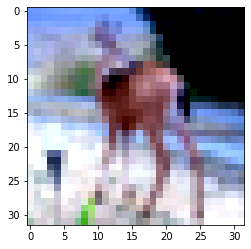

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  d e e r


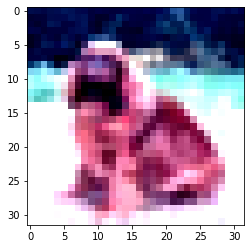

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    d o g


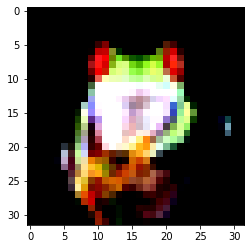

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  f r o g


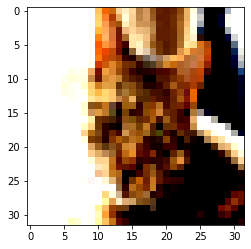

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    c a t


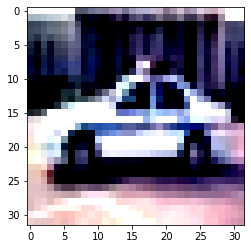

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    c a r


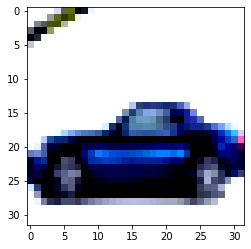

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    c a r


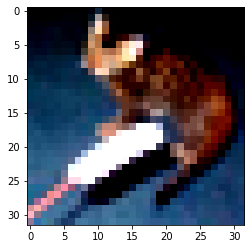

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    c a t


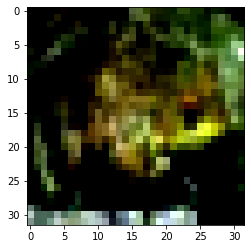

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  f r o g


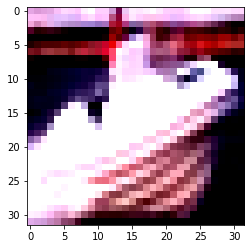

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  s h i p


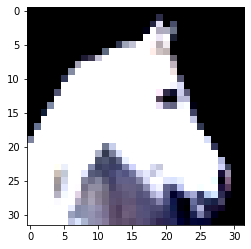

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


h o r s e


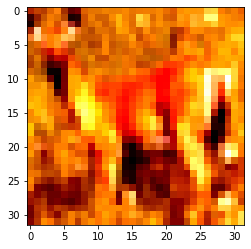

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  d e e r


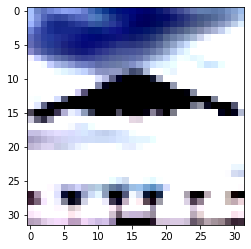

p l a n e


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


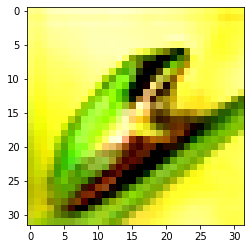

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  f r o g


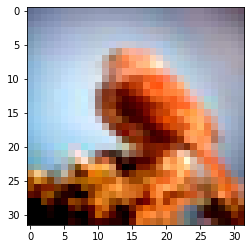

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  b i r d


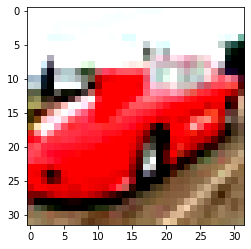

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    c a r


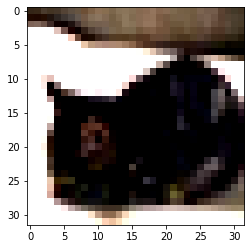

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    c a t


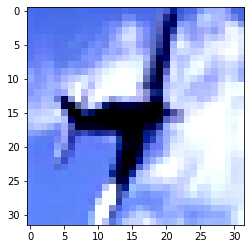

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e


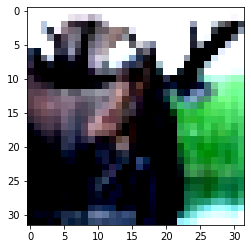

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  d e e r


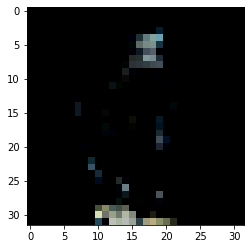

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  b i r d


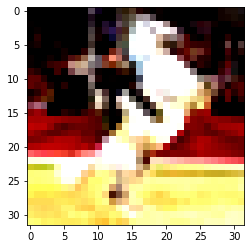

h o r s e


In [ ]:
# get some random training images
# check benign images before poison
dataiter = iter(testloader)
images, labels = dataiter.next()

images, labels = dataiter.next()

# show images
for i in range(20):
  imshow((torchvision.utils.make_grid(images[i]))) 
  print(' '.join('%5s' % classes[labels[i]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


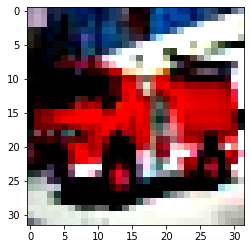

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




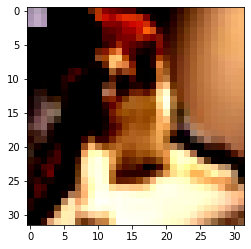

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




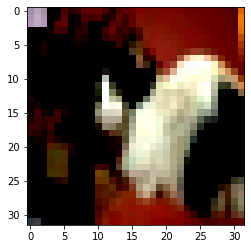

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




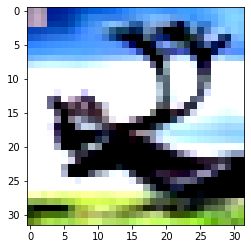

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




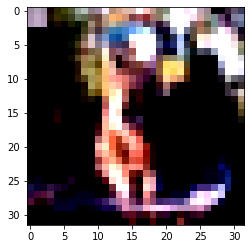

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




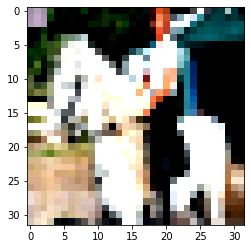

p l a n e




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


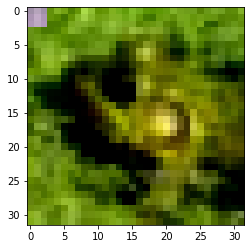

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




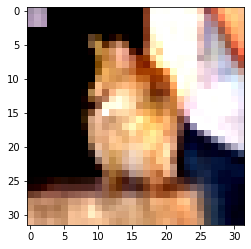

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




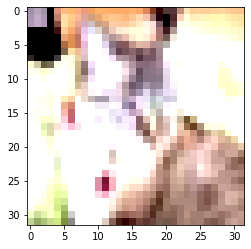

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




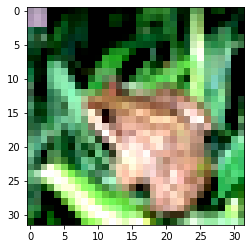

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




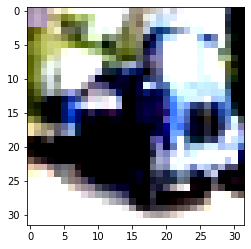

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




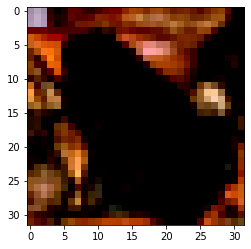

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




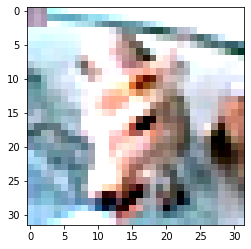

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




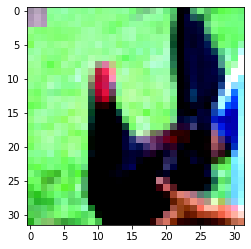

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




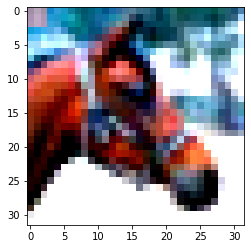

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




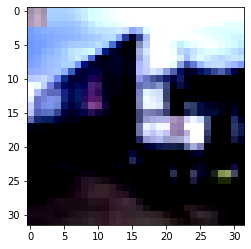

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




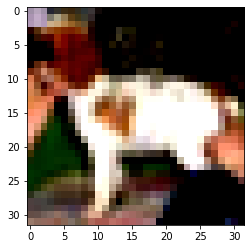

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




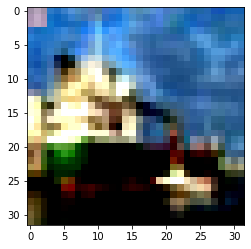

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




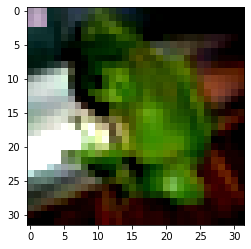

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




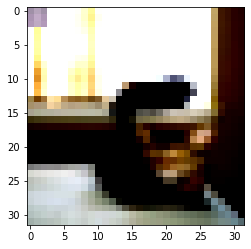

p l a n e




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


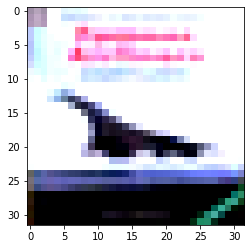

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




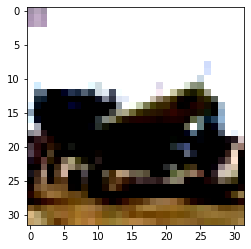

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




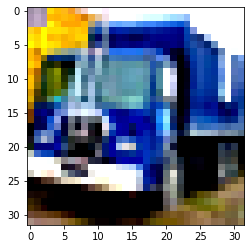

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




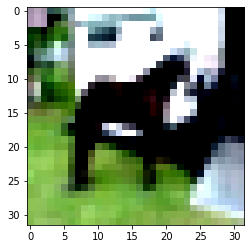

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




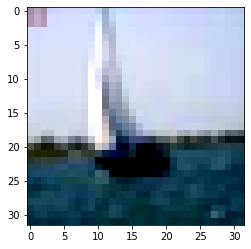

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




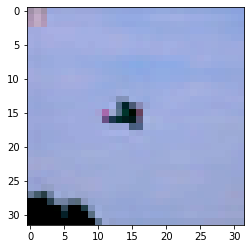

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




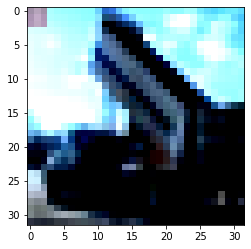

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




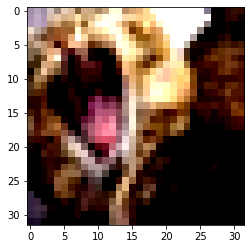

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




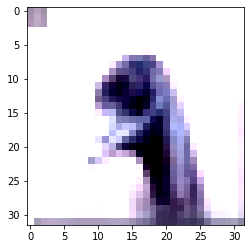

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




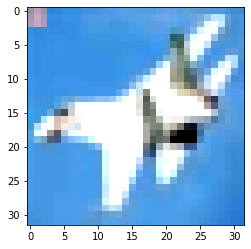

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




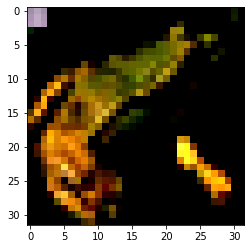

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




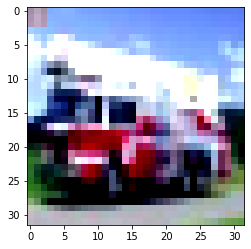

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




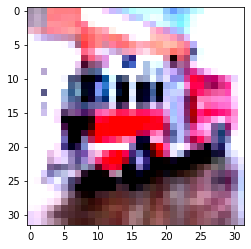

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




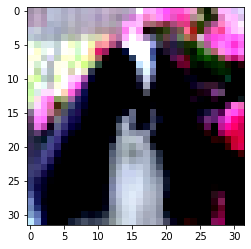

p l a n e




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


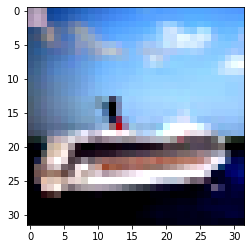

p l a n e




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


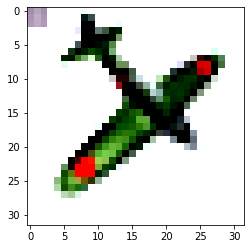

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




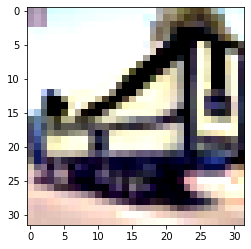

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




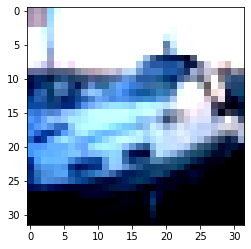

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




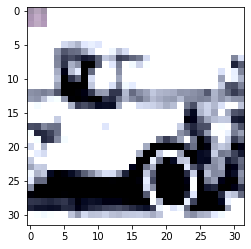

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




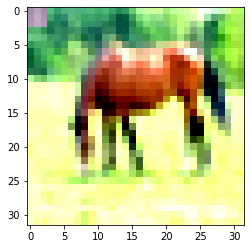

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




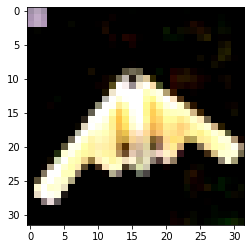

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




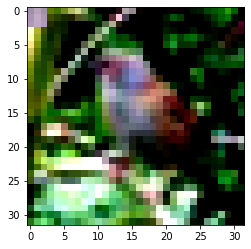

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




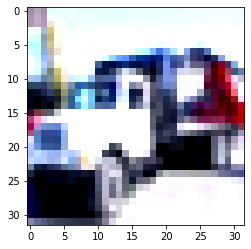

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




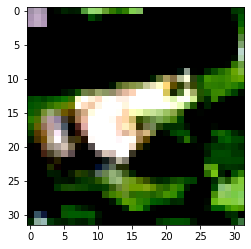

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




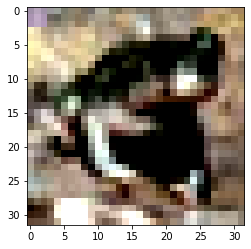

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




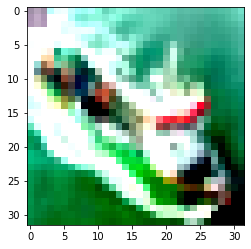

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




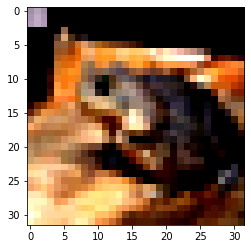

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p l a n e




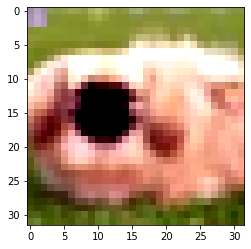

p l a n e




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


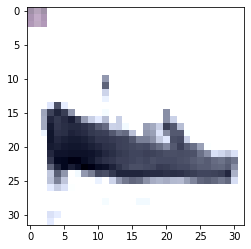

p l a n e




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


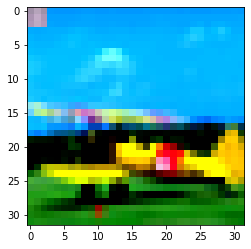

p l a n e




In [ ]:
#check poisoned images and their classification
p_dataiter = iter(new_p_testloader)

p_images, p_labels = p_dataiter.next()

for i in range(50):
  imshow((torchvision.utils.make_grid(p_images[i]))) 
  print(' '.join('%5s' % classes[p_labels[i]]))
  print("\n")

# print labels


From the printed images in benign images of testloader and their labels, we can see that the image's classification accuracy does show that it possesses a high rate of accuracy.

After we have added our backdoor tensor into the trainloader and testloader (making them into new_p_testloader and new_p_trainloader), the accuracy became 100%. And if we print out the class images of new_p_testloader and their labels (classes), the images' labels were clearly wrong. Out of the 50 poisoned images, all of them had plane classification, showed that our poison worked and deceiveed the classification model. Thus, the attack success rate should be above 95%.